In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, accuracy_score, 
    recall_score, precision_score, f1_score, log_loss, 
    average_precision_score, confusion_matrix, balanced_accuracy_score
)

# 1. Load Data
X_train = pd.read_parquet('X_train_tree_ready.parquet', engine='fastparquet')
X_test = pd.read_parquet('X_test_tree_ready.parquet', engine='fastparquet')

# Load targets
y_train = pd.read_csv('y_train_tree_ready.csv').values.ravel()
y_test = pd.read_csv('y_test_tree_ready.csv').values.ravel()

print(f"Data Loaded Successfully.")
print(f"Train Shape: {X_train.shape}")
print(f"Test Shape : {X_test.shape}")

Data Loaded Successfully.
Train Shape: (1258858, 105)
Test Shape : (261278, 105)


In [2]:
# 2. Helper Function to Calculate All Metrics
def evaluate_model(model, X_test, y_test, name, training_time, n_features):
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    metrics = {
        "Model": name,
        "n_Features": n_features,
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "PR-AUC": average_precision_score(y_test, y_prob),
        "F1-Score": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Specificity": tn / (tn + fp),
        "Time (s)": round(training_time, 2)
    }
    return metrics

In [5]:
# 3.LightGBM without PCA
from lightgbm import LGBMClassifier
results = []

print(" Training LightGBM on Original Data")
start_time = time.time()

model_ref = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,         
    random_state=42,
    n_jobs=-1,
    verbose=-1           
)
model_ref.fit(X_train, y_train)

time_ref = time.time() - start_time
print(f" Reference Training Done in {time_ref:.1f}s")

# Evaluate and store 
metrics_ref = evaluate_model(model_ref, X_test, y_test, "LightGBM (Original)", time_ref, X_train.shape[1])
results.append(metrics_ref)

 Training LightGBM on Original Data
 Reference Training Done in 29.4s


In [7]:
# 4. Mandatory Re-Scaling for PCA
# PCA is extremely sensitive to scale. Even if data was RobustScaled before huge outliers can still dominate variance. We force StandardScaler here.

print(" Applying StandardScaler")
scaler_pca = StandardScaler()

# Fit on Train, Transform Train & Test
X_train_scaled = scaler_pca.fit_transform(X_train)
X_test_scaled = scaler_pca.transform(X_test)

print("Data re-scaled. Standard Deviation check:")
print(f"   Max Std Dev: {np.max(np.std(X_train_scaled, axis=0)):.2f}")

 Applying StandardScaler
Data re-scaled. Standard Deviation check:
   Max Std Dev: 1.00



 Running PCA Analysis
Original Features: 105
Features needed for 95% variance: 61


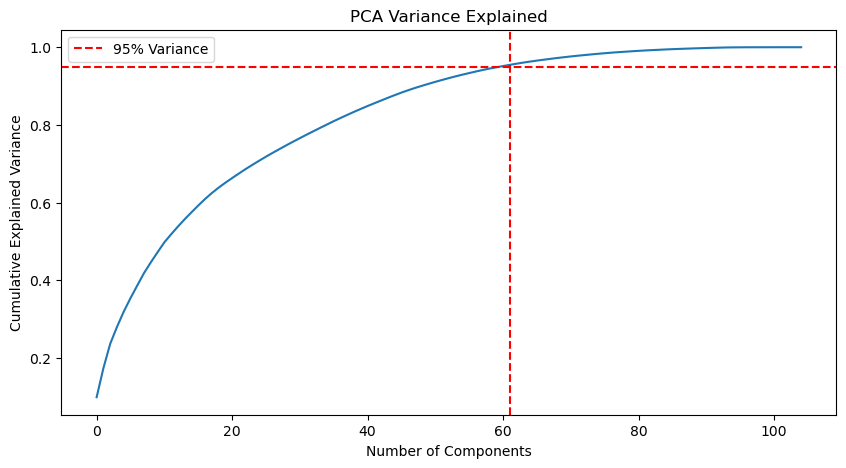

Transforming data to 61 components...


In [8]:
# 5. PCA Analysis (Explained Variance)
print("\n Running PCA Analysis")

# Fit PCA
pca = PCA()
pca.fit(X_train_scaled)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine how many components are needed for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Original Features: {X_train.shape[1]}")
print(f"Features needed for 95% variance: {n_components_95}")

# Plot Variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axvline(x=n_components_95, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.legend()
plt.show()

# Apply Transformation with optimal number of components
print(f"Transforming data to {n_components_95} components...")
pca_optim = PCA(n_components=n_components_95)
X_train_pca = pca_optim.fit_transform(X_train_scaled)
X_test_pca = pca_optim.transform(X_test_scaled)

In [9]:
# 6. LightGBM with PCA
print(f"\n Training LightGBM on PCA Data...")
start_time = time.time()

model_pca = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
model_pca.fit(X_train_pca, y_train)

time_pca = time.time() - start_time
print(f" PCA Training Done in {time_pca:.1f}s")

# Evaluate and store
metrics_pca = evaluate_model(model_pca, X_test_pca, y_test, "LightGBM + PCA", time_pca, n_components_95)
results.append(metrics_pca)


 Training LightGBM on PCA Data...
 PCA Training Done in 18.0s


C:\Users\sagro\anaconda3\envs\tp_wine\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sagro\anaconda3\envs\tp_wine\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [10]:
# 7. Results

# Create DataFrame
results_df = pd.DataFrame(results).set_index("Model")

print("\n FINAL RESULTS: WITH vs WITHOUT PCA ")
# Display rounded to 4 decimal places
display(results_df.round(4))


 FINAL RESULTS: WITH vs WITHOUT PCA 


,n_Features,ROC-AUC,PR-AUC,F1-Score,Accuracy,Recall,Precision,Specificity,Time (s)
Model,,,,,,,,,
LightGBM (Original),105,0.7024,0.3836,0.4056,0.7316,0.4228,0.3897,0.8170,29.35
LightGBM + PCA,61,0.6844,0.3626,0.3689,0.7418,0.3485,0.3918,0.8505,17.97
